In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.linalg as linalgx
import os
import time
from lib.ParticleFilter import sample_normal_model, single_step_particle_filter, normal_model_pdf, single_step_particle_filter_measurement_window
from utils.plotting import draw_ellipse, images_to_gif
from utils.filesTools import get_exp_folder
from utils.notionConnector import add_experiment_to_notion
from pathlib import Path
import scipy.stats as stats

import json

In [9]:
NUM_OF_BEACONS = 2
NUM_OF_AGENTS = 1
STATE_SIZE_2D = 2
SINGLE_RANGE_MEASUREMENT_SIZE = 1
RANGE_MEASUREMENT_SIZE = NUM_OF_BEACONS * SINGLE_RANGE_MEASUREMENT_SIZE * NUM_OF_AGENTS
TOTAL_STATE_SIZE = NUM_OF_AGENTS * STATE_SIZE_2D + NUM_OF_BEACONS * STATE_SIZE_2D
sigma_transition_agent = 0.5
sigma_transition_beacon = 0.3
sigma_measurement = 0.1
stepsize = 2
n_steps = 50
n_particles = 100
# model definition
cov_measurement = np.diag([sigma_measurement**2 for i in range(RANGE_MEASUREMENT_SIZE)])
cov_transition_agent = [sigma_transition_agent**2 for i in range(NUM_OF_AGENTS*STATE_SIZE_2D)]
# cov_transition_agent = [0 for i in range(NUM_OF_AGENTS*STATE_SIZE_2D)]
cov_transition_beacon = [sigma_transition_beacon**2 for i in range(NUM_OF_BEACONS*STATE_SIZE_2D)]
# cov_transition_beacon = [0 for i in range(NUM_OF_BEACONS*STATE_SIZE_2D)]
# cov_transition_beacon[0:6] = [sigma_transition_beacon**2]*6
cov_transition = np.diag(cov_transition_agent + cov_transition_beacon)
get_agent_index = lambda i: slice(i*STATE_SIZE_2D, i*STATE_SIZE_2D + STATE_SIZE_2D)
get_beacon_index = lambda i: slice(STATE_SIZE_2D*NUM_OF_AGENTS + i*STATE_SIZE_2D, STATE_SIZE_2D*NUM_OF_AGENTS + i*STATE_SIZE_2D + STATE_SIZE_2D)
get_agent_position = lambda x, i: x[get_agent_index(i)]
get_beacon_postion = lambda x, j: x[get_beacon_index(j)]
def state_to_agent_and_beacons_pos(x):
    agents_pos = np.zeros((NUM_OF_AGENTS, STATE_SIZE_2D))
    beacons_pos = np.zeros((NUM_OF_BEACONS, STATE_SIZE_2D))
    for i in range(NUM_OF_AGENTS):
        agents_pos[i] = get_agent_position(x, i)
    for j in range(NUM_OF_BEACONS):
        beacons_pos[j] = get_beacon_postion(x, j)
    return agents_pos, beacons_pos
def agent_and_beacons_pos_to_state(agents_pos, beacons_pos):
    x = np.zeros(TOTAL_STATE_SIZE)
    for i in range(NUM_OF_AGENTS):
        x[get_agent_index(i)] = agents_pos[i]
    for j in range(NUM_OF_BEACONS):
        x[get_beacon_index(j)] = beacons_pos[j]
    return x


def calculate_true_range_meas(x):
    """
    Function to calculate the true range measurements.
    It calculates the Euclidean distance between each agent and each beacon.
    """
    z = np.zeros(RANGE_MEASUREMENT_SIZE)
    for i in range(NUM_OF_AGENTS):
        current_agent_position = x[get_agent_index(i)]
        for j in range(NUM_OF_BEACONS):
            current_beacon_position = x[get_beacon_index(j)]
            z[i*NUM_OF_BEACONS + j] = np.linalg.norm(current_agent_position - current_beacon_position)
    return z

def measurements_model(x, cov = cov_measurement):
    '''
    Function to generate the range measurements model.
    It adds a normally distributed noise to the true range measurements.
    '''
    return calculate_true_range_meas(x) + sample_normal_model(np.zeros(RANGE_MEASUREMENT_SIZE), cov)

'''
function to calculates the likelihood of the measurements given the state.
It uses a normal probability density function with the true range measurements
as the mean and the measurement covariance as the covariance
'''
measurements_likelihood = lambda z, x: normal_model_pdf(z, calculate_true_range_meas(x), cov_measurement)

[0.11875693 0.11875693]
[0.70710678 0.70710678]


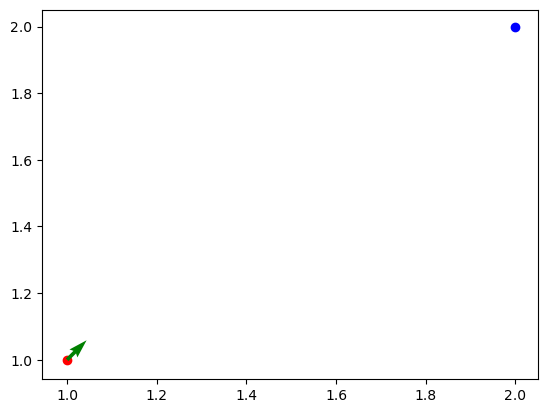

In [3]:
def calculate_gradient(x_i, z_i, normalize = True):
    #check if x is a pandas series
    # the gradient is calculated with respect to the state vector x,
    # the furmula is dL/dx = -0.5 * L(x) * dL/dz * dz/dx
    # Where L(x) is the likelihood of the measurements given the state x
    # dL/dz is the gradient of the likelihood with respect to the measurements
    # dz/dx is the gradient of the measurements with respect to the state
    if type(x_i) == pd.Series:
        x_i = x_i.values
    dzest_dx = np.zeros((RANGE_MEASUREMENT_SIZE, TOTAL_STATE_SIZE))
    for i in range(NUM_OF_AGENTS):
        agent_pos = x_i[get_agent_index(i)]
        for j in range(NUM_OF_BEACONS):
            beacon_pos = x_i[get_beacon_index(j)]
            z_est = np.linalg.norm(agent_pos - beacon_pos)
            dx = agent_pos - beacon_pos
            dzest_dx[i*NUM_OF_BEACONS + j, get_agent_index(i)] =   dx/z_est
            dzest_dx[i*NUM_OF_BEACONS + j, get_beacon_index(j)] = -dx/z_est

    dLdz = np.zeros((1, RANGE_MEASUREMENT_SIZE))
    inv_cov = np.linalg.inv(cov_measurement)
    dz = z_i - calculate_true_range_meas(x_i)
    dLdz = -2 * dz @ inv_cov

    L_of_x = measurements_likelihood(z_i, x_i)
    normlized_dLdX = dLdz @ dzest_dx # this will be normalized later, just initilize it here without common factors
    dLdx = -0.5 * L_of_x * normlized_dLdX
    # dLdx = normlized_dLdX.copy()

    
    # normalize the gradient in pairs of 2
    if normalize: 
        # normlized_dLdX = np.zeros(TOTAL_STATE_SIZE) # we dont not need to create a new array, we can use the same one
        for i in range(NUM_OF_AGENTS):
            norm = np.linalg.norm(dLdx[get_agent_index(i)])
            normlized_dLdX[get_agent_index(i)] = dLdx[get_agent_index(i)]/norm
        for j in range(NUM_OF_BEACONS):
            norm = np.linalg.norm(dLdx[get_beacon_index(j)])
            normlized_dLdX[get_beacon_index(j)] = dLdx[get_beacon_index(j)]/norm

    return dLdx, normlized_dLdX

#function to calculate the gradient of the likelihood for only one agent and one beacon
def calculate_gradient_single_agent_beacon(agent_pos, beacon_pos,z_i):
    MEAS_SIZE_2D = 1
    STATE_SIZE_2D = 2
    z_est = np.linalg.norm(agent_pos - beacon_pos)
    dx = agent_pos - beacon_pos
    dzest_dx = np.zeros((1, STATE_SIZE_2D))
    dzest_dx[0:STATE_SIZE_2D] = dx/z_est

    dLdz = np.zeros((1, 1))
    inv_cov = np.array([1/sigma_measurement])
    dz = np.array([z_i - z_est])
    dLdz = -2 * dz * inv_cov
    L_of_x = normal_model_pdf(z_i, z_est, sigma_measurement**2)
    normlized_dLdX = dLdz @ dzest_dx
    dLdx = -0.5 * L_of_x * normlized_dLdX
    normlized_dLdX = dLdx / np.linalg.norm(dLdx)
    return dLdx, normlized_dLdX

#test the single agent and beacon gradient function
agent_pos = np.array([1, 1])
beacon_pos = np.array([2, 2])
z_i = 1.41
dLdx, normlized_dLdX = calculate_gradient_single_agent_beacon(agent_pos, beacon_pos,z_i)
print(dLdx)
print(normlized_dLdX)

#plot the results od the test with arrow showing the gradient
plt.figure()
plt.scatter(agent_pos[0], agent_pos[1], color='r', label='agent')
plt.scatter(beacon_pos[0], beacon_pos[1], color='b', label='beacon')
plt.quiver(agent_pos[0], agent_pos[1], normlized_dLdX[0], normlized_dLdX[1], color='g', label='gradient')

/tmp/ipykernel_21193/1966375257.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


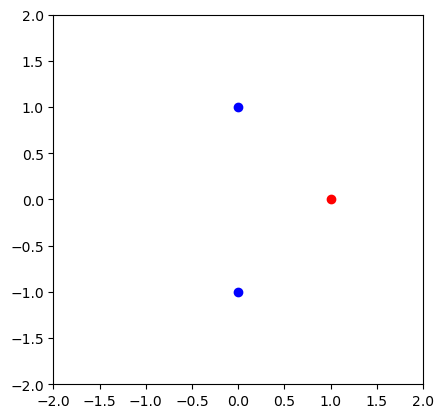

In [4]:
agent_pos_0  = np.array([1, 0])
beacon0_pos_0 = np.array([0, 1])
beacon1_pos_0 = np.array([0, -1])
#plot positions
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')

ax.plot(agent_pos_0[0], agent_pos_0[1], 'ro')
ax.plot(beacon0_pos_0[0], beacon0_pos_0[1], 'bo')
ax.plot(beacon1_pos_0[0], beacon1_pos_0[1], 'bo')
fig.show()

[ 1.  0.  0.  1.  0. -1.]
9.413909557881531
9.501899934637486
9.589753655327783
9.677451762693913
9.764975172965652
9.852304682445252
9.939420974211448
10.026304624941053
10.112936111844474
10.199295819712313
10.285364048069312
10.371121018432532
10.456546881669903
10.541621725455766
10.626325581819438
10.710638434782974
10.794540228084335
10.878010872981651
10.961030256134823
11.043578247559553
11.125634708650571
11.207179500268525
11.288192490886843
11.368653564793796
11.448542630344988
11.52783962826194
11.60652453997153
11.684577395982162
11.761978284291011
11.838707358818146
11.914744847861952
11.99007106257131
12.064666405429241
12.138511378742786
12.211586593134335
12.28387277602896
12.355350780132547
12.426001591895773
12.495806339958222
12.564746303568054
12.6328029209711
12.699957797764982
12.76619271521231
12.831489638508058
12.8958307249957
12.959198332326839
13.021575026559221
13.082943590187686
13.143287030103034
13.202588585473608
13.260831735544318
13.318000207348142
13

/tmp/ipykernel_21193/1270691856.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Text(0.5, 1.0, 'likelihood of the measurements given the state')

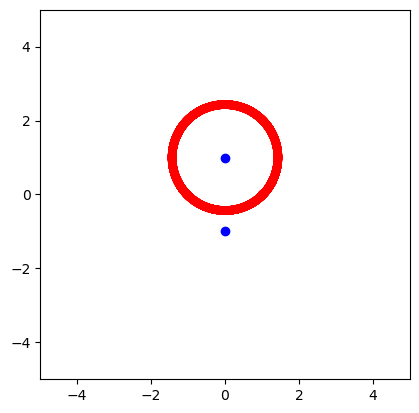

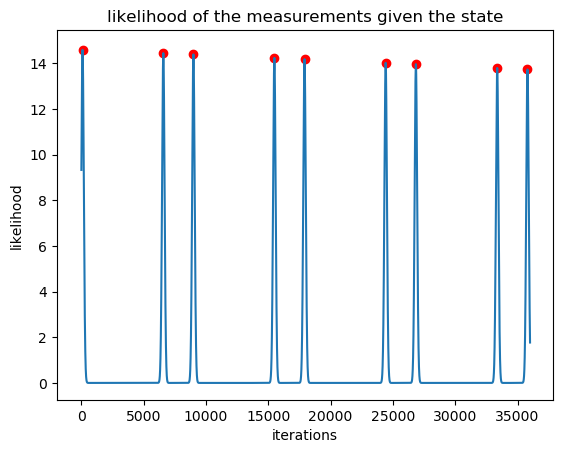

In [26]:
#initial state
x_0 = agent_and_beacons_pos_to_state([agent_pos_0], [beacon0_pos_0, beacon1_pos_0])
print(x_0)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_aspect('equal')

ax.plot(agent_pos_0[0], agent_pos_0[1], 'ro')
ax.plot(beacon0_pos_0[0], beacon0_pos_0[1], 'bo')
ax.plot(beacon1_pos_0[0], beacon1_pos_0[1], 'bo')
#plot the direction of the gradient
a = get_agent_position(x_0, 1)
x = x_0
stepsize = 0.001
prev_move_dir = None
z = measurements_model(x)
measurements_likelihood_log = [measurements_likelihood(z, x)]
for i in range(2*18000):
    dLdx, normlized_dLdX = calculate_gradient_single_agent_beacon(x[get_agent_index(0)],x[get_beacon_index(0)], z[0])
    move_dir = np.array([normlized_dLdX[1], -normlized_dLdX[0]])
    if prev_move_dir is not None and np.dot(prev_move_dir, move_dir) < 0:
        move_dir *= -1
    ax.quiver(x[get_agent_index(0)][0], x[get_agent_index(0)][1], move_dir[0], move_dir[1], color='r')
    x[get_agent_index(0)] += stepsize * move_dir
    print(measurements_likelihood(z, x))
    measurements_likelihood_log.append(measurements_likelihood(z, x))
    prev_move_dir = move_dir
fig.show()
measurements_likelihood_log = np.array(measurements_likelihood_log)
## find all local maxima
maxima = []
for i in range(1, len(measurements_likelihood_log)-1):
    if measurements_likelihood_log[i] > measurements_likelihood_log[i-1] and measurements_likelihood_log[i] > measurements_likelihood_log[i+1]:
        maxima.append(i)

maxima = np.array(maxima)
#plot the likelihood of the measurements given the state
plt.figure()
plt.plot(measurements_likelihood_log)
plt.scatter(maxima, measurements_likelihood_log[maxima], color='r')

plt.xlabel('iterations')
plt.ylabel('likelihood')
plt.title('likelihood of the measurements given the state')

In [ ]:
x_0 = agent_and_beacons_pos_to_state([agent_pos_0], [beacon0_pos_0, beacon1_pos_0])
print(x_0)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')

ax.plot(agent_pos_0[0], agent_pos_0[1], 'ro')
ax.plot(beacon0_pos_0[0], beacon0_pos_0[1], 'bo')
ax.plot(beacon1_pos_0[0], beacon1_pos_0[1], 'bo')
#plot the direction of the gradient
dLdx, normlized_dLdX = calculate_gradient(x_0, measurements_model(x_0))
a = get_agent_position(x_0, 1)
x = x_0
stepsize = 0.001
for i in range(100):
    dLdx, normlized_dLdX = calculate_gradient(x, measurements_model(x))
    ax.quiver(x[get_agent_index(0)][0], x[get_agent_index(0)][1], normlized_dLdX[get_agent_index(0)][1], -normlized_dLdX[get_agent_index(0)][0], color='r')
    x[get_agent_index(0)] += stepsize * np.array([normlized_dLdX[get_agent_index(0)][1], -normlized_dLdX[get_agent_index(0)][0]])
fig.show()